Add feedback to the RF measurements of P1 sweeps. Inherits from `rf.ipynb`

In [1]:
%matplotlib inline
import local_broom

Added 'quench/' and 'quench/libraries' for easy importing.


In [2]:
# LabOne Q:
#from laboneq.simple import *

from laboneq.dsl.experiment import (
    #Section,
    Experiment,
    ExperimentSignal,
    #Sweep,
    pulse_library
)
from laboneq.dsl.device import DeviceSetup
from laboneq.dsl.session import Session
from laboneq.dsl.calibration import (
    Calibration,
    SignalCalibration,
    Oscillator
)

from laboneq.dsl.enums import (
    AcquisitionType,
    AveragingMode,
    SectionAlignment,
    PortMode,
    ModulationType
)

from laboneq.dsl import LinearSweepParameter

from laboneq.pulse_sheet_viewer.pulse_sheet_viewer import show_pulse_sheet
from laboneq.contrib.example_helpers.plotting.plot_helpers import plot_simulation

from pathlib import Path
import time

import matplotlib.pyplot as plt
import numpy as np
from tqdm.autonotebook import tqdm

from monty import Monty

C:\Users\LD2007\AppData\Local\Temp\ipykernel_26920\1438599358.py:37: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
experiment = {
    "desc": "Test the feedback with RF over changing P1."
}

monty = Monty("rf.set feedback", experiment)

Loading existing experiment (ignoring given experiment parameters)
Note that no experimental data has been loaded.
Next run will have id 4


In [4]:
descriptor = """
instruments:
  SHFQC:
  - address: DEV12158
    uid: device_shfqc
    interface: 1gbe
    options: SHFQC/QC6CH

connections:
  device_shfqc:
    - iq_signal: set/drive_line
      ports: SGCHANNELS/0/OUTPUT
    - iq_signal: p1/drive_line
      ports: SGCHANNELS/1/OUTPUT
    - iq_signal: p2/drive_line
      ports: SGCHANNELS/2/OUTPUT
    - iq_signal: j1/drive_line
      ports: SGCHANNELS/3/OUTPUT
    - iq_signal: set/measure_line
      ports: [QACHANNELS/0/OUTPUT]
    - acquire_signal: set/acquire_line
      ports: [QACHANNELS/0/INPUT]
"""


In [5]:
# Define and Load our Device Setup
device_setup = DeviceSetup.from_descriptor(
    yaml_text=descriptor,
    server_host="localhost",  # ip address of the LabOne dataserver used to communicate with the instruments
    server_port="8004",  # port number of the dataserver - default is 8004
    setup_name="my_setup",  # setup name
)

# Create shortcuts to logical signals (LSG) for convenience
lsg = {
    qubit_name: device_setup.logical_signal_groups[qubit_name].logical_signals
    for qubit_name in device_setup.logical_signal_groups.keys()
}
# Use like lsg["set"]["drive_line"]

# perform experiments in emulation mode only? - if True, also generate dummy data for fitting
emulate = False

# create and connect to a session
session = Session(device_setup=device_setup)
session.connect(do_emulation=emulate)

[2024.07.16 14:51:49.821] INFO    Logging initialized from [Default inline config in laboneq.laboneq_logging] logdir is C:\Users\LD2007\Documents\Si_CMOS_james\quench\june\laboneq_output\log
[2024.07.16 14:51:49.824] INFO    VERSION: laboneq 2.32.0
[2024.07.16 14:51:49.834] INFO    Connecting to data server at localhost:8004
[2024.07.16 14:51:49.939] INFO    Connected to Zurich Instruments LabOne Data Server version 24.04 at localhost:8004
[2024.07.16 14:51:50.979] INFO    Configuring the device setup
[2024.07.16 14:51:51.083] INFO    The device setup is configured


### Definitions

In [6]:
def plot_sweeper(f, result, unwrap = True, deg = True, xlabel="Frequency (GHz)", ylabel="Power (dBm)", monty=None):
    """Plot results from Sweeper"""
    f = f/1e9
    power = 10*np.log10(np.abs(result)**2/50*1000)
    phase = np.unwrap(np.angle(result, deg = deg)) if unwrap is True else np.angle(result, deg = deg)
    phase_unit = 'deg' if deg else 'rad'
    fig, (ax0, ax1) = plt.subplots(nrows = 2, sharex = True)
    ax0.plot(f, power, '.-', color = 'steelblue', label = 'power')
    #ax0.legend(loc='upper left')
    ax0.set_ylabel(ylabel)
    ax1.plot(f, phase, '.-', color = 'orange', label = 'phase')
    #ax1.legend(loc='upper left')
    ax1.set_xlabel(xlabel)
    fig.align_ylabels([ax0, ax1])
    ax0.grid()
    ax1.grid()
    ax1.set_ylabel(f'Phase ({phase_unit})')
    plt.tight_layout()
    if monty is not None:
        ax0.set_title(monty.identifier + "." + monty.runname)
        monty.savefig(plt, "sweep")
    else:
        plt.show()

In [7]:
def compile_run(session, exp_params, exp):
    compiler_settings = {
        "OUTPUT_EXTRAS": True,
        "MAX_EVENTS_TO_PUBLISH": 1000,
    }
    compiled_exp = session.compile(exp, compiler_settings=compiler_settings)
    results = session.run(compiled_exp)
    root = Path("/Users/LD2007/Documents/Si_CMOS_james/pulse_sheets")
    root.mkdir(parents=True, exist_ok=True)
    show_pulse_sheet(root.joinpath(f"{exp_params["exp_name"]}"), compiled_exp)
    #if exp_params["plot_simulation"] == 1:
    #plot_simulation(compiled_exp, start_time=exp_params["plt_start_time"], length=exp_params["plt_length"])
    return results

In [8]:
def topower(res, unwrap=True, deg=True):
    power = 10*np.log10(np.abs(res)**2/50*1000)
    phase = np.unwrap(np.angle(res, deg = deg)) if unwrap is True else np.angle(res, deg = deg)
    #phase_unit = 'deg' if deg else 'rad'
    return power, phase

### P1 without feedback

In [9]:
def simplep1(params):
    exp = Experiment(uid=params["exp_name"],
                     signals = [
                        ExperimentSignal("drive_set", map_to=lsg["set"]["drive_line"]),
                        ExperimentSignal("drive_p1", map_to=lsg["p1"]["drive_line"]),
                        ExperimentSignal("measure", map_to=lsg["set"]["measure_line"]),
                        ExperimentSignal("acquire", map_to=lsg["set"]["acquire_line"]),
                    ]
    )
    
    with exp.acquire_loop_rt(uid="shots",
                             count=params["num_averages"],
                             acquisition_type = AcquisitionType.SPECTROSCOPY,
                             averaging_mode = AveragingMode.SEQUENTIAL):
        with exp.sweep(uid='sweep p1', parameter=params["p1_sweep"]):  #amp_sweep_g1):
            with exp.section(uid="drivers", alignment = SectionAlignment.RIGHT):
                with exp.section(uid="control"):
                    # note that the phase does not affect the output amplitude
                    exp.play(signal="drive_set",
                             pulse=params["set_dr_pulse"],  # g1_pulse,
                             amplitude = params["set_dr_amp"],  # amp_sweep_g1,
                             phase = 180)
                    
                    exp.play(signal="drive_p1",
                             pulse = params["p1_pulse"],
                             amplitude = params["p1_amp"],
                             phase = 180)
                    
                with exp.section(uid="readout"):
                    # necessary to add measurement/acquire pulse?
                    
                    # exp.acquire(signal="acquire",
                    #             handle="results",
                    #             length=50e-6)
                    
                    exp.measure(acquire_signal="acquire",
                                handle = "results",
                                integration_length=params["set_integration"],
                                # reset_delay=1000e-6  # use reserve section following instead
                               )

                # relax time after readout - for qubit relaxation to groundstate and signal processing
                with exp.section(uid="relax", length=params["wait_after_int"]):
                    exp.reserve(signal="measure")
                    exp.reserve(signal="acquire")
                    exp.reserve(signal="drive_set")
                            
    cal = Calibration()
    
    cal["drive_set"] = SignalCalibration(
        local_oscillator=Oscillator(frequency=0),
        oscillator=Oscillator(frequency=0),
        port_mode=PortMode.LF,
        range=params["set_dr_pout"])
    
    cal["drive_p1"] = SignalCalibration(
        local_oscillator=Oscillator(frequency=0),
        oscillator=Oscillator(frequency=0),
        port_mode=PortMode.LF,
        range=params["p1_dr_pout"])
    
    cal["acquire"] = SignalCalibration(
        local_oscillator=Oscillator(frequency=0),
        port_mode=PortMode.LF,
        oscillator=Oscillator(frequency=params["set_freq"]),
        # port_delay = 100e-6,
        range=params["set_acq_pout"])
    
    exp.set_calibration(cal)

    return exp

In [ ]:
set_dr_pulse_len = 100e-6
p1_pulse_len = 20e-6

set_dr_pulse = pulse_library.const(uid="set_dr_pulse", amplitude=0.1, length=set_dr_pulse_len, can_compress=True)
p1_pulse = pulse_library.const(uid="p1_pulse", amplitude=0.1, length=p1_pulse_len, can_compress=True)

p1_sweep = LinearSweepParameter("p1_sweep", start=0.0, stop=0.1, count=101)

simple_p1_params = {
    "exp_name": "p1_sweep",
    "num_averages": 2**3,

    "set_dr_pulse":  set_dr_pulse,
    "set_dr_amp": 1.0,
    "set_integration": 50e-6,  # integration time for measurement
    "set_dr_pout": 5,  # output power range
    "set_acq_pout": 0,
    "set_freq": 395.0e6,

    "p1_sweep": p1_sweep,
    "p1_pulse": p1_pulse,
    "p1_amp": 1.0,
    "p1_dr_pout": 5,

    "wait_after_int": 0,
}

monty.newrun("simple p1 sweep", simple_p1_params)
exp = simplep1(simple_p1_params)
results = compile_run(session, simple_p1_params, exp)
data = results.acquired_results["results"].data
monty.save({"data": data})
plot_sweeper(p1_sweep, data)

In [ ]:
data

In [ ]:
plot_sweeper(p1_sweep, data)

### P1 with feedback

Copied from `pulse_tests.ipynb`

In [10]:
def feedbackp1(params):
    exp = Experiment(uid=params["exp_name"],
                     signals = [
                        ExperimentSignal("drive_set", map_to=lsg["set"]["drive_line"]),
                        ExperimentSignal("drive_p1", map_to=lsg["p1"]["drive_line"]),
                        ExperimentSignal("measure", map_to=lsg["set"]["measure_line"]),
                        ExperimentSignal("acquire", map_to=lsg["set"]["acquire_line"]),
                    ]
    )

    # sweep over P1 in python time, but run each acquire experiement at high speed

    with exp.sweep(uid='p1_sweep', parameter=params["p1_sweep"]):
        with exp.acquire_loop_rt(uid="shots",
                                 count=params["num_averages"],
                                 acquisition_type = AcquisitionType.SPECTROSCOPY,
                                 averaging_mode = AveragingMode.SEQUENTIAL):
        
            with exp.section(uid="drivers", alignment = SectionAlignment.RIGHT):
                with exp.section(uid="control"):
                    # note that the phase does not affect the output amplitude
                    exp.play(signal="drive_set",
                             pulse=params["set_dr_pulse"],  # g1_pulse,
                             amplitude = params["set_dr_amp"],  # amp_sweep_g1,
                             phase = 180)
                    
                    exp.play(signal="drive_p1",
                             pulse = params["p1_pulse"],
                             amplitude = params["p1_amp"],
                             phase = 180)
                    
                with exp.section(uid="readout"):
                    # necessary to add measurement/acquire pulse?
                    
                    # exp.acquire(signal="acquire",
                    #             handle="results",
                    #             length=50e-6)
                    
                    exp.measure(acquire_signal="acquire",
                                handle = "results",
                                integration_length=params["set_integration"],
                                # reset_delay=1000e-6  # use reserve section following instead
                               )

                # relax time after readout - for qubit relaxation to groundstate and signal processing
                with exp.section(uid="relax", length=params["wait_after_int"]):
                    exp.reserve(signal="measure")
                    exp.reserve(signal="acquire")
                    exp.reserve(signal="drive_set")

        exp.call(params["feedback_func"], amplitude=params["p1_sweep"])
                            
    cal = Calibration()
    
    cal["drive_set"] = SignalCalibration(
        local_oscillator=Oscillator(frequency=0),
        oscillator=Oscillator(frequency=0),
        port_mode=PortMode.LF,
        range=params["set_dr_pout"])
    
    cal["drive_p1"] = SignalCalibration(
        local_oscillator=Oscillator(frequency=0),
        oscillator=Oscillator(frequency=0),
        port_mode=PortMode.LF,
        range=params["p1_dr_pout"])
    
    cal["acquire"] = SignalCalibration(
        local_oscillator=Oscillator(frequency=0),
        port_mode=PortMode.LF,
        oscillator=Oscillator(frequency=params["set_freq"]),
        # port_delay = 100e-6,
        range=params["set_acq_pout"])
    
    exp.set_calibration(cal)

    return exp

In [11]:
def feedback(session, amplitude: float):
    # See https://docs.zhinst.com/pdf/ziSHFQC_UserManual.pdf page 66, 68 and 69

    #session.devices["device_shfqc"].sgchannels[5].awg.outputamplitude(amplitude)
    #time.sleep(0.1)
    
    print(f"amplitude = {amplitude} currently")

    return amplitude

Started new run feedback_p1_sweep
[2024.07.16 14:52:38.328] INFO    Resolved modulation type of oscillator 'osc_5' on signal 'acquire' to HARDWARE
[2024.07.16 14:52:38.329] INFO    Resolved modulation type of oscillator 'osc_3' on signal 'drive_p1' to HARDWARE
[2024.07.16 14:52:38.330] INFO    Resolved modulation type of oscillator 'osc_1' on signal 'drive_set' to HARDWARE
[2024.07.16 14:52:38.331] INFO    Starting LabOne Q Compiler run...
[2024.07.16 14:52:38.338] INFO    Schedule completed. [0.004 s]
[2024.07.16 14:52:38.388] INFO    Code generation completed for all AWGs. [0.048 s]
[2024.07.16 14:52:38.388] INFO    Completed compilation step 1 of 101. [0.054 s]
[2024.07.16 14:52:38.390] INFO    Skipping compilation for next step(s)...
[2024.07.16 14:52:38.404] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.16 14:52:38.405] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.07.16 14:52:38.406] INFO     ─────

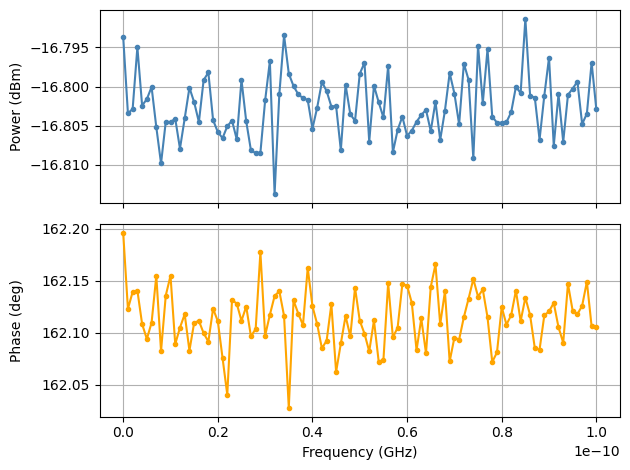

In [13]:
set_dr_pulse_len = 100e-6
p1_pulse_len = 20e-6

set_dr_pulse = pulse_library.const(uid="set_dr_pulse", amplitude=0.1, length=set_dr_pulse_len, can_compress=True)
p1_pulse = pulse_library.const(uid="p1_pulse", amplitude=0.1, length=p1_pulse_len, can_compress=True)

p1_sweep = LinearSweepParameter("p1_sweep", start=0.0, stop=0.1, count=101)

feedback_p1_params = {
    "exp_name": "p1_sweep",
    "num_averages": 2**3,

    "set_dr_pulse":  set_dr_pulse,
    "set_dr_amp": 1.0,
    "set_integration": 50e-6,  # integration time for measurement
    "set_dr_pout": 5,  # output power range
    "set_acq_pout": 0,
    "set_freq": 395.0e6,

    "p1_sweep": p1_sweep,
    "p1_pulse": p1_pulse,
    "p1_amp": 1.0,
    "p1_dr_pout": 5,

    "wait_after_int": 0,
    "feedback_func": feedback,
}

session.register_neartime_callback(feedback_p1_params["feedback_func"])

monty.newrun("feedback p1 sweep", feedback_p1_params)
exp = feedbackp1(feedback_p1_params)
results = compile_run(session, feedback_p1_params, exp)
data = results.acquired_results["results"].data
monty.save({"data": data})
plot_sweeper(p1_sweep, data)